# Ecommerce Logistics Analysis, Part 3
### Does the number of days early the shipment is delivered have an effect on the review score of the product in the shipment?
    -Lower review scores?
    -Less likely to place additional orders?
    
    -On opposite end, does a longer estimated shipping time result in less sales?


In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from table_audit import table_audit_function

%matplotlib inline

#Create context manager to handle connection to SQLite database and return dataframe from query
def run_query(q):
    with sqlite3.connect('data/ecommerce.db') as conn:
        return pd.read_sql_query(q,conn)

Below is a schema summarizing the relationships between the tables in the database I created in Part 1:
![title](images/schema_rearranged_2.jpg)

### Missing values investigation

In Part 3, dealing w/ data in the delivery_difference view (which comes from the orders_modified table) w/ a left join to the order_reviews table. There are 441 null review_score values for the delivered shipments. I will not be including these rows in section 2 of this analysis (no reliable way to impute the missing values here -> the missing values here are not missing at random). Alternatively, would have same result w/ an inner join and wouldn't have to drop the null values b/c those 441 orders are excluded b/c they don't have a corresponding order_id in the order_reviews table. This is what I did for query \#9 and query \#10 (q9 and q10, respectively).

In [2]:
q1a = '''
SELECT
    dd.order_id,
    dd.delivery_estimate_difference,
    orev.review_score
FROM delivery_difference dd
LEFT JOIN order_reviews_modified orev ON orev.order_id=dd.order_id
'''

q1b = '''
SELECT
    v.order_id,
    v.delivery_estimate_difference,
    orev.review_score
FROM delivery_difference v
INNER JOIN order_reviews_modified orev ON orev.order_id=v.order_id
'''

q2 = '''
SELECT
    orev.review_score,
    AVG(v.delivery_estimate_difference) mean_delivery_diff
FROM delivery_difference v
INNER JOIN order_reviews_modified orev ON orev.order_id=v.order_id
GROUP BY orev.review_score
'''

q3 = '''
SELECT
    v.order_id,
    CASE
    WHEN v.delivery_estimate_difference < -1 THEN "Late delivery"
    WHEN v.delivery_estimate_difference  >= -1 AND v.delivery_estimate_difference <= 0 THEN "On time"
    WHEN v.delivery_estimate_difference  > 0 THEN "Early delivery"
    END
    AS delivery_status,
    orev.review_score 
FROM delivery_difference v
INNER JOIN order_reviews orev ON orev.order_id=v.order_id
'''

In [3]:
q1a_df = run_query(q1a)
table_audit_function(q1a_df)
print(q1a_df.shape)

q1b_df = run_query(q1b)
table_audit_function(q1b_df)
print(q1b_df.shape)

print(q1a_df.shape[0]-q1b_df.shape[0])

There are 441 null values in the field review_score
There are no blank values in any of the columns for this table.
(93258, 3)
There are no null values in any of the columns for this table.
There are no blank values in any of the columns for this table.
(92817, 3)
441


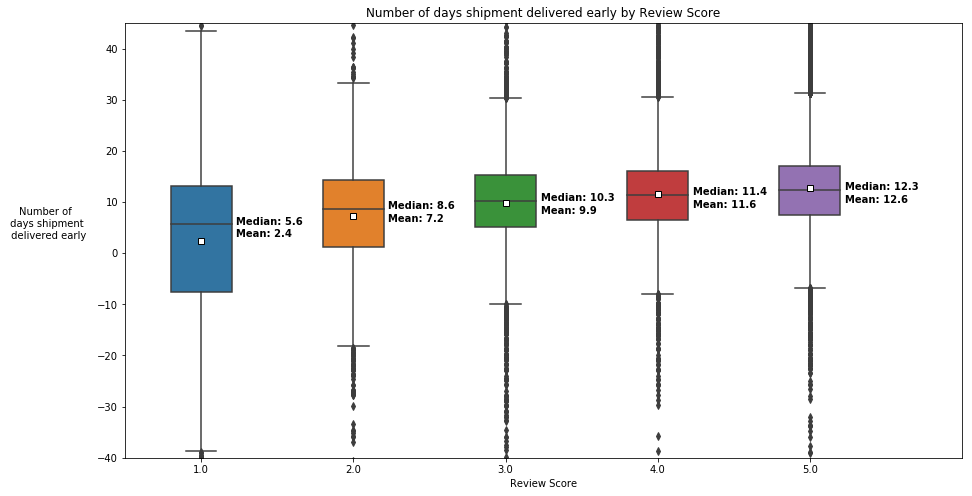

In [4]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)

df_deliv_rev = run_query(q1a)
#Drop the 441 shipments that were delivered but didn't have a review score:
df_deliv_rev = df_deliv_rev.dropna()

#Zoom in
sns.boxplot(x='review_score', y='delivery_estimate_difference', data=df_deliv_rev, width=0.4, showmeans=True, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)
ax1.set(ylim=(-40,45))
ax1.set_ylabel('Number of \n days shipment \n delivered early', rotation=0,labelpad=50)
#ax1.set_xtick
ax1.set_xlabel('Review Score')
ax1.set(xlim=(-0.5,5))
ax1.set_title('Number of days shipment delivered early by Review Score')

# Add mean labels to the box plot
mean_values = run_query(q2)['mean_delivery_diff']
mean_labels = [str(np.round(mv, 1)) for mv in mean_values]

# Add median labels to the box plot
median_days_early_estimate_by_review_score = run_query(q1a).groupby('review_score').median()
median_values = median_days_early_estimate_by_review_score['delivery_estimate_difference'].values
median_labels = [str(np.round(med_v, 1)) for med_v in median_values]
pos = range(len(mean_values))

for tick in range(len(mean_values)):
    # x_position, y_position, string_label, size, color, weight
    ax1.text(tick+0.23, median_values[tick] -2.5, 'Mean: ' + mean_labels[tick], size=10, color='black', weight='semibold')
    ax1.text(tick+0.23, median_values[tick] + 0, 'Median: ' + median_labels[tick], size=10, color='black', weight='semibold')

plt.show()

Insights:<br>
Visually, it looks like the number of days the shipment is delivered early may have a relationship with the review score of the product that is shipped: The mean and median number of days the shipment is delivered early increases as the review score increases.

A more in depth investigation is required to see if there is a statistically significant relationship between the number of days the shipment is delivered earlyand the review score of the product that is shipped. 

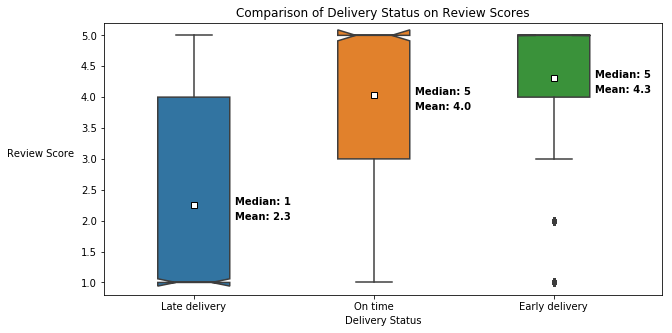

In [5]:
# Add mean labels to the box plot
mean_review_score = run_query(q3).groupby('delivery_status').mean()
mean_values = mean_review_score['review_score'].values 

#Need to re-order the elements in the list so that they correspond to the "late, on time, early" order in the plot below:
order_vals = [1, 2, 0]
mean_values = [mean_values[i] for i in order_vals]
mean_labels = [str(np.round(mv, 1)) for mv in mean_values]


# Add median labels to the box plot
median_review_score = run_query(q3).groupby('delivery_status').median()
median_values = median_review_score['review_score'].values    
median_values = [median_values[i] for i in order_vals]
median_labels = [str(np.round(med_v, 1)) for med_v in median_values]

df_7 = run_query(q3)
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
sns.boxplot(x='delivery_status', y='review_score', width=0.4, data=df_7, notch=True,  showmeans=True, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)
ax1.set_ylabel('Review Score', rotation=0, labelpad=40)
ax1.set_xlabel('Delivery Status')
ax1.set(xlim=(-0.5,2.6))
ax1.set_title('Comparison of Delivery Status on Review Scores')

x_pos = [1,2,3]

for tick in range(len(mean_values)):
#   x_position, y_position, string_label, size, color, weight
    ax1.text(tick+0.23, mean_values[tick] -0.25, 'Mean: ' + mean_labels[tick], size=10, color='black', weight='semibold')
    ax1.text(tick+0.23, mean_values[tick], 'Median: ' + median_labels[tick], size=10, color='black', weight='semibold')



plt.show()

Insights:<br>
Visually, it looks like the delivery status of the shipment (whether it is delivered late, on time or early) may have a relationship with the review score of the product that is shipped: Late deliveries have a median and mean review score of 1 and 2.3, respectively. The review scores are dramatically increased for shipments that were delivered on time or early: On-time deliveries have a median and mean review score of 5 and 4.0, respectively. Early deliveries have a median and mean review score of 5 and 4.3, respectively.

A more in depth investigation is required to see if there is a statistically significant relationship between the delivery status of the shipment and the review score of the product that is shipped. A one-way ANOVA test could be used (note that the assumptions are later determined not to be met for this b/c the distributions are not parametric). Use a Kruskal-Wallis test to see if there is a statistically significantly difference between the median review scores for deliveries that are delivered late, on-time and early. 

### Statistical Analysis (continue later)

This is a really good idea but I will do this later b/c it is not super important. Definitely do at some point b/c being able to say I did statistical analyses in this project will be a huge plus! Need to rank the review scores where if there are 500 1's and 1,000 2's, then I think all 1,000 2's are labeled as 501. Repeat for scores 3,4 and 5. This is the array we will be using.

For the graph above I want to know if there is a statistically significant difference between the mean rating between the 'early delivery', 'on time' and 'late delivery' groups. <br>

I will use a one-way ANOVA test (b/c I am trying to determine whether there are any statistically significant differences between the means of three or more independent groups).<br>

Null hypothesis: The mean rating value for the 'early delivery' group equals the mean rating value for the 'On time' group equals the mean rating value for the 'late delivery' group. <br>

Alternative hypothesis: There are at least two groups that have statistically significant different mean rating values from eachother (doesn't tell which groups, the one-way ANOVA test is an omnibus test statistic).<br>

Independent variable: Delivery status (early delivery, on time or late delivery)<br>
Dependent variable: Rating value<br>

Assumptions of the one-way ANOVA test:
1. The dependent variable (in this case the rating value) is normally distributed for each group (early delivery, on time, late delivery). I need to confirm that the rating value distribution for early delivery is normal, the rating value distribution for on time delivery is normal and that the rating value distribution for late delivery is normal.

2. Homogeneity of variances

3. independent observations

Source:
https://statistics.laerd.com/statistical-guides/one-way-anova-statistical-guide.php

1. Histogram of review scores for early delviery, on time, late delivery (3 histograms): are all of the distributions normal? <br>

In [6]:
# Histogram of review scores for early delviery, on time, late delivery (3 histograms): are all of the distributions normal?

q11 = '''
SELECT
    v.order_id,
    CASE
    WHEN v.delivery_estimate_difference < -1 THEN "Late delivery"
    WHEN v.delivery_estimate_difference  >= -1 AND v.delivery_estimate_difference <= 0 THEN "On time"
    WHEN v.delivery_estimate_difference  > 0 THEN "Early delivery"
    END
    AS delivery_status,
    orev.review_score review_score
FROM delivery_difference v
INNER JOIN order_reviews orev ON orev.order_id=v.order_id
'''

run_query(q11)

df_3 = run_query(q11)

ed = df_3[df_3['delivery_status']=='Early delivery']
ot = df_3[df_3['delivery_status']=='On time'] 
ld = df_3[df_3['delivery_status']=='Late delivery'] 

(array([3454.,    0.,  554.,    0.,    0.,  698.,    0.,  643.,    0.,
        1041.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

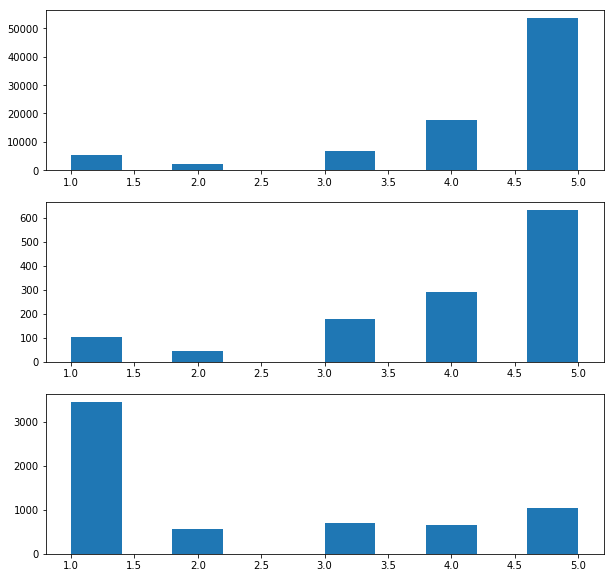

In [7]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.hist(ed['review_score'])
ax2.hist(ot['review_score'])
ax3.hist(ld['review_score'])

# These plots don't look to be even remotely normally distributed....


Assumptions for one-way ANOVA test are NOT met. <br>

Will use non-parametric statistical test b/c as we can see the data is not normally distributed. <br>

The Kruskal-Wallis test can be used to determine if there is a statistically significant difference between the median review scores between shipments that are delivered early, delivered on time or delivered late. <br>

The Kruskal-Wallist test requires that the review scores be ranked. The tied values need to be assigned the average of the ranks they would have received had they not been tied. The array of rankings of the review scores for shipments that are delivered early, on time or late are the inputs to the Kruskal-Wallis test. <br>

Null hypothesis: The review scores for shipments that are delivered early, delivered on time and delivered late are all drawn from the same distribution. The median review score for shipments that were delivered early, delivered on time and delivered late are all the same.

Alternative hypothesis: The review scores for shipments that are delivered early, delivered on time and delivered late are  NOT all drawn from the same distribution. The median review score for shipments that were delivered early, delivered on time and delivered late are NOT all the same.

Assumptions:
1. The review scores must be independent between each data sample (shipments that are delivered early, on time and late).
2. Each data sample (shipments that are delivered early, on time or late) must have 5 or more observations (the data samples are allowed to differ in size). 

Kruskal-Waliis formula:
![title](images/kruskalwallisformula_updated.JPG)  

Where:<br>
ni = size of the ith sample <br>
rij = rank of jth observation in ith sample (rank amongst all samples combined)<br>
rbari = average rank across all observations in ith sample<br>
rbar = average of all rbari<br>

Source:
https://statistics.laerd.com/spss-tutorials/kruskal-wallis-h-test-using-spss-statistics.php 
https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance

In [8]:
# Step 1: Rank the review scores and assign tied review scores the average of the ranks they would have recieved if they weren't tied.
#from scipy.stats import kruskal, rankdata

#df_3['ranked_review_scores'] = rankdata(df_3['review_score'], method='average')
#ed = df_3[df_3['delivery_status']=='Early delivery']
#ot = df_3[df_3['delivery_status']=='On time'] 
#ld = df_3[df_3['delivery_status']=='Late delivery'] 

#df_3[['review_score','ranked_review_scores']].head(30)



# Note that the kruskal function in the scipy.stats module has an overflow error for large arrays.
# This is a documented error that has not been fixed but may be updated in SciPy 1.4.0. 
# https://github.com/scipy/scipy/issues/7759 
# stat, p = kruskal(ed['review_score'], ot['review_score'], ld['review_score'])

# I will need to implement this manually:


#print(stat, p)


# Step 2: Perform manual Kruskal-Wallis test:
#def kruskalwallis_manual(sample_1, sample_2, sample_3):
#    n_1 = len(sample_1)
#    n_2 = len(sample_2)
#    n_3 = len(sample_3)
    
#    N = n_1 + n_2 + n_3
    
#    c = 3
    
#    r_bar_1 = sample_1.mean()
#    r_bar_2 = sample_2.mean()
#    r_bar_3 = sample_3.mean()
    
#    r_bar = (r_bar_1 + r_bar_2 + r_bar_3)/3
    
#    numerator = n_1 * (r_bar_1 - r_bar)**2 + n_2 * (r_bar_2 - r_bar)**2 + n_3 * (r_bar_3 - r_bar)**2
    
#    denom
    
    
#    H = ((12/(n*(n+1)))*((T_1**2)/n_1 + (T_2**2)/n_2 + (T_3**2)/n_3))-3*(n+1)
    
#    return (H, n_1, n_2, n_3, n, c, T_1, T_2, T_3)

#h_score = kruskalwallis_manual(ed['review_score'], ot['review_score'], ld['review_score'])

#print(h_score)

#For a 2 degrees of freedom (3-1) and an alpha value of 0.05, the critical chi square value is 5.99.

# Since the critical chi-square value (5.99) is greater than the H_value (-288,746), we fail to reject the null hypothesis.
# There is NOT a statisitcally-significant difference in the median review scores between shipments that are delivered early, on time or late.
